Importing the Necessary libraries

In [4]:
import jax
import jax.numpy as jnp
import optax
import tensorflow_probability.substrates.jax as tfp
import warnings
warnings.filterwarnings('ignore')

Defining the model

In [5]:
from typing import Sequence, Tuple
from jax import random
import jax.numpy as jnp
from flax import linen

class MultiLayerPerceptronRegressor(linen.Module):
    features: Sequence[int] = (5,10,15,2)

    def setup(self):
        self.layers = [linen.Dense(feat) for feat in self.features]

    def __call__(self, inputs):
        x = inputs
        for i, lyr in enumerate(self.layers):
            x = lyr(x)
            if i != len(self.layers) - 1:
                x = linen.relu(x)
        return x



In [34]:
# Generate some random toy data
# Simple 1d regression dataset
x = jnp.array(jnp.linspace(0, 1, 100))

f = lambda x: 2 * x + 1
y = f(x) + jax.random.normal(jax.random.PRNGKey(42), x.shape)



samples = x.shape
features = 1



Defining the loss function

In [6]:
def Loss_tfp(weights, input_data, actual):
    preds = model.apply(weights, input_data)[:,0]
    variance = jnp.exp(model.apply(weights, input_data)[:,1])
    # print(variance)
    dist = tfp.distributions.Normal(preds, jnp.sqrt(variance))
    return -jnp.sum(dist.log_prob(actual))/(len(preds))

Model summary


In [7]:
from tqdm import tqdm

Ensemble

In [18]:
l = []
e =[]
n_ensembles = 6
distribution = jnp.ones((len(y),n_ensembles))
responsibility = jnp.ones((len(y),n_ensembles))
mean_predictions = jnp.ones((len(y),n_ensembles))
var_predictions =jnp.ones((len(y),n_ensembles))

for ensembles in tqdm(range(n_ensembles)):
  seed = random.PRNGKey(ensembles)
  epochs=1000

  model = MultiLayerPerceptronRegressor() ## Define Model
  random_arr = jax.random.normal(key=seed, shape=(5, features))
  params = model.init(seed, random_arr) ## Initialize Model Parameters

  optimizer = optax.sgd(learning_rate=1/1e2) ## Initialize SGD Optimizer using OPTAX

  optimizer_state = optimizer.init(params)
  loss_grad = jax.value_and_grad(Loss_tfp)

  for i in range(1,epochs+1):
      e.append(i)
      loss_val, gradients = loss_grad(params, x.reshape(-1,1),y) ## Calculate Loss and Gradients
      # print(loss_val)
      l.append(loss_val)

      updates, optimizer_state = optimizer.update(gradients, optimizer_state)
      params = optax.apply_updates(params, updates) ## Update weights
      #if i % 100 == 0:
         # print('MLE After {} Epochs : {:.2f}'.format(i, loss_val))
  print(loss_val)
  preds = model.apply(params, x.reshape(-1,1))
  y_pred, variance = preds[:,0] , jnp.exp(preds[:,1])
  dist = tfp.distributions.Normal(y_pred, jnp.sqrt(variance))
  log_pdf = dist.log_prob(y)
  distribution = distribution.at[:,ensembles].set(-log_pdf)
  mean_predictions = mean_predictions.at[:,ensembles].set(y_pred)
  var_predictions = var_predictions.at[:,ensembles].set(variance)

  0%|          | 0/6 [00:00<?, ?it/s]

1.435237


 33%|███▎      | 2/6 [06:49<13:34, 203.55s/it]

1.4358548


 50%|█████     | 3/6 [10:06<10:01, 200.47s/it]

1.564216


 67%|██████▋   | 4/6 [13:21<06:36, 198.41s/it]

1.4349972


 83%|████████▎ | 5/6 [16:38<03:17, 197.91s/it]

1.4363054


100%|██████████| 6/6 [19:55<00:00, 199.27s/it]

1.4331757


In [19]:
print(MultiLayerPerceptronRegressor().tabulate(jax.random.PRNGKey(0), random_arr))


                     MultiLayerPerceptronRegressor Summary                      
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ path     ┃ module          ┃ inputs        ┃ outputs       ┃ params          ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│          │ MultiLayerPerc… │ float32[5,1]  │ float32[5,2]  │ layers_0:       │
│          │                 │               │               │   bias:         │
│          │                 │               │               │ float32[5]      │
│          │                 │               │               │   kernel:       │
│          │                 │               │               │ float32[1,5]    │
│          │                 │               │               │ layers_1:       │
│          │                 │               │               │   bias:         │
│          │                 │               │               │ float32[10]     │
│          │               

In [33]:
import pickle


with open('var_6.pickle', 'wb') as f:
    pickle.dump(var_predictions, f)


In [20]:
mixture_weight = 1/n_ensembles
distribution = mixture_weight*distribution
for row in range(len(distribution)):
  responsibility = responsibility.at[row,:].set(distribution[row,:]/jnp.sum(distribution[row,:]))

mixture_weights = jnp.sum(responsibility, axis =0)/jnp.sum(responsibility)
print(mixture_weights)

[0.1635738  0.16348743 0.18273841 0.16344328 0.1634745  0.16328262]


Assuming that the all the models have equal weights,

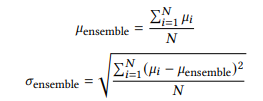

In [21]:
mean_ensemble = jnp.mean(mean_predictions, axis=1)
var_ensemble = jnp.sum(jnp.square(var_predictions - mean_ensemble.reshape(-1,1)),axis =1)/len(y)

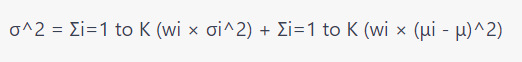

In [22]:
mean_ensemble_weighted = jnp.sum(mean_predictions*mixture_weights, axis=1)

var_ensemble_weighted = jnp.sum(mixture_weights*((mean_predictions-mean_ensemble_weighted.reshape(-1,1))**2+ var_predictions),axis=1) 


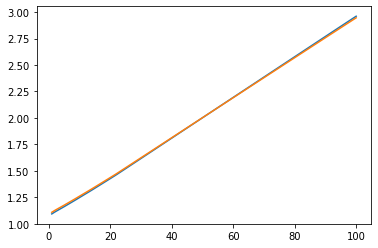

In [25]:
import matplotlib.pyplot as plt
xv = jnp.linspace(1,100,100)
plt.plot(xv,mean_ensemble)
plt.plot(xv,mean_ensemble_weighted)
plt.show()

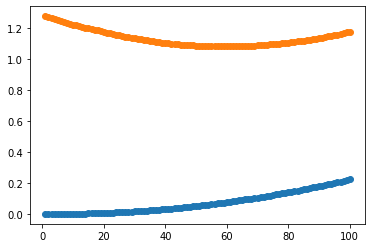

In [24]:
import matplotlib.pyplot as plt
x = jnp.linspace(1,100,100)
plt.scatter(x,var_ensemble)
plt.scatter(x,var_ensemble_weighted)
plt.show()


**Computing the variance of noise**

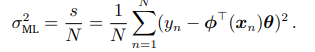

Therefore, the maximum likelihood estimate of the noise variance is the
empirical mean of the squared distances between the noise-free function
values ϕ
⊤
(xn)θ and the corresponding noisy observations yn at input locations xn.

In [35]:
# estimating the sigma of noise:

sig = jnp.sum(jnp.square(f(x)-y))/len(y)
sig*sig

Array(1.0810636, dtype=float32)

In [ ]:
preds = model2.apply(params, x.reshape(-1,1))
y_pred, variance = preds[:,0] , jnp.exp(preds[:,1])
y_pred_1 = y_pred + 2*jnp.sqrt(variance)
y_pred_2 = y_pred - 2*jnp.sqrt(variance)


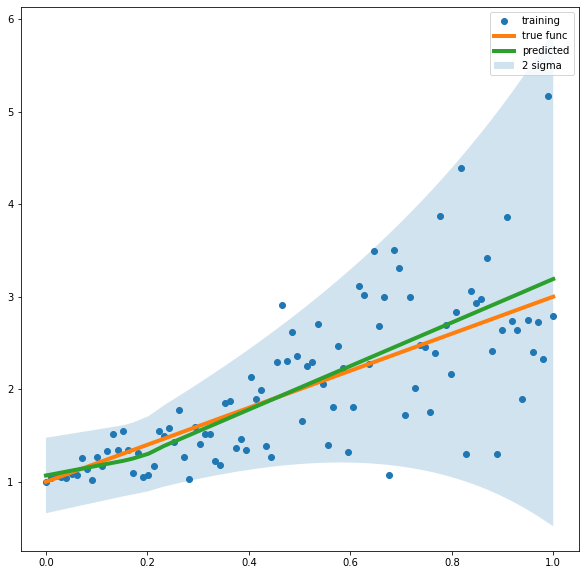

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize =(10,10))
plt.plot(x, y, 'o', label='training')
plt.plot(x, 2*x+1,linewidth = 4,label ='true func')
plt.plot(x, y_pred,linewidth = 4,label ='predicted')
plt.fill_between(x,y_pred_1,y_pred_2, alpha=0.2, label = '2 sigma')
plt.legend()